# Lemon Farm - Customer Segmentation

### Import library

In [386]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np


### Read data from postgreSQL

In [387]:
conn = psycopg2.connect(
    dbname="nay-krit",
    user="nay-krit",
    password="1111",
    host="sql.dfhead.com",
    port= 5432
)

sql_query = "SELECT * FROM lf_data"
lf_data_ori = pd.read_sql(sql_query, conn)

conn.close()


/tmp/ipykernel_2486/4280691889.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lf_data_ori = pd.read_sql(sql_query, conn)


In [388]:
lf_data_ori.info()
lf_data_ori.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_date    2800 non-null   object 
 1   bill_time    2800 non-null   object 
 2   bill_no      2800 non-null   object 
 3   member_id    1603 non-null   object 
 4   sku_code     2800 non-null   object 
 5   sku_name     2800 non-null   object 
 6   qty          2800 non-null   int64  
 7   sales        2800 non-null   float64
 8   sex          1385 non-null   object 
 9   age          1601 non-null   float64
 10  location     1601 non-null   object 
 11  cat_code     2800 non-null   object 
 12  category     2748 non-null   object 
 13  day_name     2800 non-null   object 
 14  time_of_day  2800 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 328.2+ KB


,bill_date,bill_time,bill_no,member_id,sku_code,sku_name,qty,sales,sex,age,location,cat_code,category,day_name,time_of_day
0,2022-09-07,11:17:24 น.,e76360ed,None,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,None,NaN,None,7009,Coffee (Bottle),2_Wednesday,1_Noon
1,2022-09-07,08:35:22 น.,a6bd1288,14bc04ee,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,F,59.0,North,7009,Coffee (Bottle),2_Wednesday,0_Morning
2,2022-09-07,08:51:39 น.,ac1311ce,None,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,None,NaN,None,7009,Coffee (Bottle),2_Wednesday,0_Morning
3,2022-09-07,14:22:55 น.,4f889f95,8e60e131,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,M,57.0,North,7009,Coffee (Bottle),2_Wednesday,2_Afternoon
4,2022-09-07,17:23:21 น.,69cb0d58,2c156018,7009017,อเมริกาโน่เย็น 240 ml#ขวด,1,79.8579,M,41.0,North,7009,Coffee (Bottle),2_Wednesday,2_Afternoon


## Experiment 1
menu category clustering

In [389]:
lf_data = lf_data_ori[['member_id', 'sales', 'category']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1603 non-null   object 
 1   sales      2800 non-null   float64
 2   category   2748 non-null   object 
dtypes: float64(1), object(2)
memory usage: 65.8+ KB


,member_id,sales,category
0,None,79.8579,Coffee (Bottle)
1,14bc04ee,79.8579,Coffee (Bottle)
2,None,79.8579,Coffee (Bottle)
3,8e60e131,79.8579,Coffee (Bottle)
4,2c156018,79.8579,Coffee (Bottle)


In [390]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1574 entries, 1 to 2797
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1574 non-null   object 
 1   sales      1574 non-null   float64
 2   category   1574 non-null   object 
dtypes: float64(1), object(2)
memory usage: 49.2+ KB


In [391]:
aggregations = {
    'sales': 'sum',
    'category': 'max'
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1036 non-null   object 
 1   sales      1036 non-null   float64
 2   category   1036 non-null   object 
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


,member_id,sales,category
0,004a4488,234.5826,Salad
1,009e11b6,71.5453,Salad
2,00f07ddd,209.6270,Salad
3,00f0e4d4,117.2913,Salad
4,0100b137,117.3002,Salad


In [392]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     1036 non-null   float64
 1   category  1036 non-null   object 
dtypes: float64(1), object(1)
memory usage: 16.3+ KB


,sales,category
0,234.5826,Salad
1,71.5453,Salad
2,209.6270,Salad
3,117.2913,Salad
4,117.3002,Salad


In [393]:
lf_data = pd.get_dummies(lf_data, columns=['category'], prefix=['category'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     1036 non-null   float64
 1   category_Coffee           1036 non-null   int64  
 2   category_Coffee (Bottle)  1036 non-null   int64  
 3   category_Honey1           1036 non-null   int64  
 4   category_Juice            1036 non-null   int64  
 5   category_Salad            1036 non-null   int64  
 6   category_Salmon Steak     1036 non-null   int64  
 7   category_Soup             1036 non-null   int64  
 8   category_Tea              1036 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 73.0 KB


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
0,234.5826,0,0,0,0,1,0,0,0
1,71.5453,0,0,0,0,1,0,0,0
2,209.6270,0,0,0,0,1,0,0,0
3,117.2913,0,0,0,0,1,0,0,0
4,117.3002,0,0,0,0,1,0,0,0


In [394]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
0,0.127180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.017377,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.110373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.048186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.048192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [395]:
def Silhouette_coef(df):
    Num_K = [i+2 for i in range(9)]
    silhouette_coef = []

    for k in Num_K:
        kmeans = KMeans(n_clusters=k, random_state=1,)
        model = kmeans.fit(df)
        labels = model.labels_
        silhouette_coef.append(metrics.silhouette_score(df, labels, metric='euclidean'))
        silhouette_coef
    print(Num_K,silhouette_coef)
    plt.scatter(Num_K,silhouette_coef)
    plt.plot(Num_K,silhouette_coef)
    plt.title('Silhouette coefficients')
    plt.ylabel('Scores')
    plt.xlabel('k')
    plt.show()

In [396]:
def wcss(df):
    Num_K = [i+2 for i in range(9)]
    WCSS = []

    for k in Num_K:
        kmeans = KMeans(n_clusters=k, random_state=1,)
        model = kmeans.fit(df)
        WCSS.append(model.inertia_)
        WCSS
    print(Num_K, WCSS)
    plt.scatter(Num_K,WCSS )
    plt.plot(Num_K,WCSS )
    plt.title('WCSS')
    plt.ylabel('Scores')
    plt.xlabel('k')
    plt.show()

### Silhouette_coef

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.7005239228155206, 0.803058063564343, 0.8709715277708445, 0.8998691758767429, 0.9252049024774829, 0.9416522553987309, 0.950230672685227, 0.8418345661407085, 0.8416582438746171]


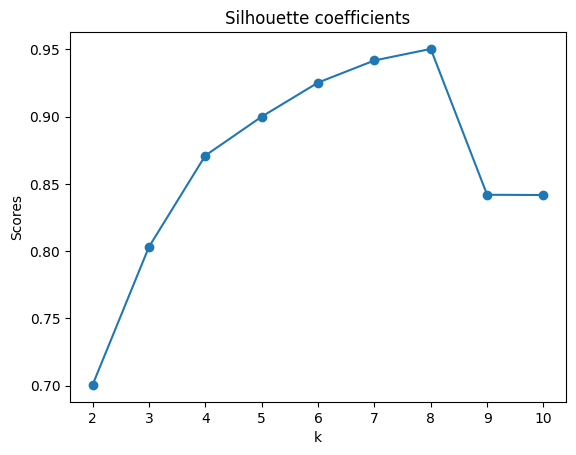

In [397]:
Silhouette_coef(lf_data_scale)

### wcss

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [283.4600842646004, 171.18896237739955, 96.93568277630172, 63.915882093447614, 34.872760260533006, 16.85916926361403, 8.302875061975364, 5.940081478546473, 4.6781757554820596]


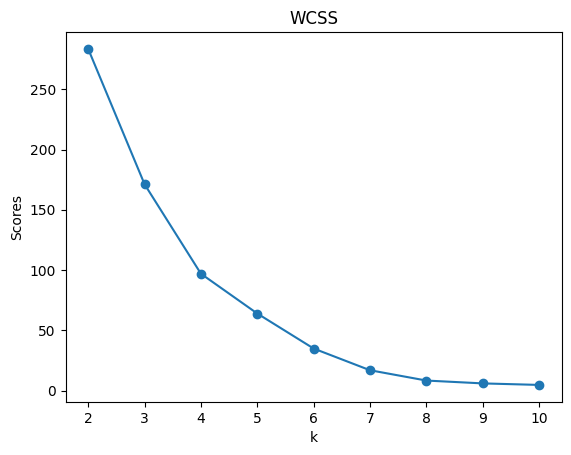

In [398]:
wcss(lf_data_scale)

In [399]:
def pca_plot(df, colors):
    pca_2 = PCA(n_components=2)
    pca_2_result = pca_2.fit_transform(df)
    print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
    print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
    dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df.columns, index=['PC_1', 'PC_2'])
    print('\n\n', dataset_pca)

    print("\n*************** Most important features *************************")
    print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
    print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
    print("\n******************************************************************")

    x = pca_2_result[:, 0]
    y = pca_2_result[:, 1]

    plt.scatter(x, y, c=[colors[i] for i in kmeans.labels_], alpha=0.5, s=300)  # plot different colors per cluster
    plt.title('clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    centroids_pca = pca_2.transform(kmeans.cluster_centers_)
    for i in range(len(centroids_pca)):
        plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1], marker='X', s=80, linewidths=1.5,color=colors[i], edgecolors="black")
    

    plt.show()
    

### kmean

In [400]:
kmeans = KMeans(n_clusters=4, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### pca plot

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Explained variation per principal component: [0.52318559 0.21533477]
Cumulative variance explained by 2 principal components: 73.85%


          sales  category_Coffee  category_Coffee (Bottle)  category_Honey1  \
PC_1  0.004347         0.298762                  0.371088         0.017709   
PC_2  0.009307         0.705874                  0.705573         0.004331   

      category_Juice  category_Salad  category_Salmon Steak  category_Soup  \
PC_1        0.053607        0.873154               0.061451       0.059422   
PC_2        0.014435        0.055072               0.016831       0.016504   

      category_Tea  
PC_1      0.011117  
PC_2      0.002670  

*************** Most important features *************************
As per PC 1:
 category_Coffee (Bottle)    0.371088
category_Salad              0.873154
Name: PC_1, dtype: float64


As per PC 2:
 category_Coffee             0.705874
category_Coffee (Bottle)    0.705573
Name: PC_2, dtype: float64

*******************************

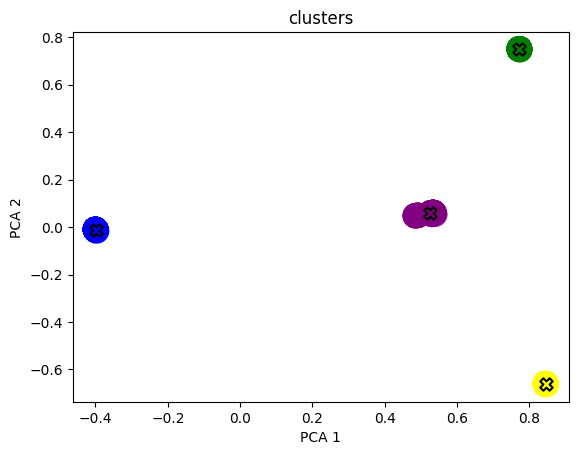

In [401]:
colors = ['purple', 'blue', 'green', 'yellow']
pca_plot(lf_data_scale, colors)

In [402]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()

Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)


### Cluster 1

In [403]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,118.000000,118.0,118.0,118.000000,118.000000,118.0,118.000000,118.000000,118.000000
mean,250.364095,0.0,0.0,0.093220,0.262712,0.0,0.296610,0.288136,0.059322
std,246.809846,0.0,0.0,0.291981,0.441984,0.0,0.458711,0.454826,0.237234
min,67.380100,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,104.813500,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,197.149200,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,229.582600,0.0,0.0,0.000000,1.000000,0.0,1.000000,1.000000,0.000000
max,1530.559500,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [404]:
print("ยอดบิลสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: {}".format(np.array(Cluster1_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: {}".format(np.array(Cluster1_inv['sales']).std()))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: {} คน".format(Cluster1_inv.shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Tea'] == 1.0)].shape[0]))



ยอดบิลสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: 250.36409491525424
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: 245.76181680759072
ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: 118 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee: 0 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee (Bottle): 0 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Honey1: 11 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Juice: 31 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salad: 0 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salmon Steak: 35 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Soup: 34 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Tea: 7 คน


### Cluster 2

In [405]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,666.000000,666.0,666.0,666.0,666.0,666.0,666.0,666.0,666.0
mean,163.986127,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
std,112.748054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25%,104.822400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,209.627000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
max,1166.207800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [406]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: {}".format(np.array(Cluster2_inv['sales']).std()))
print("ในคลัสเตอร์สองที่เรามีลูกค้า: {} คน".format(Cluster2_inv.shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Tea'] == 1.0)].shape[0]))



ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: 163.98612732732735
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: 112.66337617303247
ในคลัสเตอร์สองที่เรามีลูกค้า: 666 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee (Bottle): 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Juice: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salad: 666 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Soup: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Tea: 0 คน


### Cluster 3

In [407]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,118.000000,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0
mean,132.475081,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,99.036471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,59.067500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,79.866800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,96.492000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,151.400975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,758.694500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [408]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: {}".format(np.array(Cluster3_inv['sales']).std()))
print("ในคลัสเตอร์สามที่เรามีลูกค้า: {} คน".format(Cluster3_inv.shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Tea'] == 1.0)].shape[0]))



ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: 132.47508050847458
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: 98.6159325057365
ในคลัสเตอร์สามที่เรามีลูกค้า: 118 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee: 118 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee (Bottle): 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Juice: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salad: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Soup: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Tea: 0 คน


### Cluster 4

In [409]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,134.000000,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0
mean,157.799323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
std,135.695232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,45.744200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,159.715800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,908.312600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [410]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: {}".format(np.array(Cluster4_inv['sales']).std()))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้า: {} คน".format(Cluster4_inv.shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Tea'] == 1.0)].shape[0]))



ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: 157.79932313432838
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: 135.18795803043608
ในคลัสเตอร์สี่ที่เรามีลูกค้า: 134 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee (Bottle): 134 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Juice: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salad: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Soup: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Tea: 0 คน


### Experiment 1 Summary

kmean clustering ทำการแบ่งกลุ่มของข้อมูลจากประเภทของเมนูออกเป็น 4 กลุ่มหลักๆ ได้แก่ กลุ่มสลัด กลุ่มกาแฟแก้ว กลุ่มกาแฟขวด และกลุ่มอาหาอื่นๆ ซึ่งกลุ่มสลัดนั้นเป็นกลุ่มที่มีจำนวนลูกค้าเยอะมากที่สุด ที่ 666 คน ถือได้ว่าเป็นเมนูยอดนิยมของร้าน แต่มียอดบิลเฉลี่ยของลูกค้าในกลุ่มนี้อยู่ที่ 164 บาท แต่ว่ากลุ่มที่มียอดบิลมากที่สุดนั้นเป็นกลุ่มอาหารอื่นๆ ซึ่งมียอดบิลเฉลี่ยของลูกค้าในกลุ่มนี้อยู่ที่ 250 บาท แต่มีจำนวนคนในกลุ่มอยู่เพียง 118 คน ดังนั้น ทางร้านควรมีการออกโปรโมชั่นของเมนูอาหารประเภทนี้ เพื่อกระตุ้นให้มีจำนวนลูกค้าในกลุ่มเมนูนี้มากยิ่งขึ้น นำไปสู่รายได้ของร้านที่มากขึ้น

และในส่วนของกลุ่มที่เป็นเมนูกาแฟ พบว่า กาแฟแบบขวดนั้น เป็นที่นิยมมากกว่า และมียอดบิลเฉลี่ยที่สูงกว่ากาแฟแบบแก้วอีกด้วย

## Experiment 2

menu category and time_of_day clustering

In [411]:
lf_data = lf_data_ori[['member_id', 'sales', 'category', 'time_of_day']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1603 non-null   object 
 1   sales        2800 non-null   float64
 2   category     2748 non-null   object 
 3   time_of_day  2800 non-null   object 
dtypes: float64(1), object(3)
memory usage: 87.6+ KB


,member_id,sales,category,time_of_day
0,None,79.8579,Coffee (Bottle),1_Noon
1,14bc04ee,79.8579,Coffee (Bottle),0_Morning
2,None,79.8579,Coffee (Bottle),0_Morning
3,8e60e131,79.8579,Coffee (Bottle),2_Afternoon
4,2c156018,79.8579,Coffee (Bottle),2_Afternoon


In [412]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1574 entries, 1 to 2797
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1574 non-null   object 
 1   sales        1574 non-null   float64
 2   category     1574 non-null   object 
 3   time_of_day  1574 non-null   object 
dtypes: float64(1), object(3)
memory usage: 61.5+ KB


In [413]:
aggregations = {
    'sales': 'sum',
    'category': 'max',
    'time_of_day': 'max'
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1036 non-null   object 
 1   sales        1036 non-null   float64
 2   category     1036 non-null   object 
 3   time_of_day  1036 non-null   object 
dtypes: float64(1), object(3)
memory usage: 32.5+ KB


,member_id,sales,category,time_of_day
0,004a4488,234.5826,Salad,2_Afternoon
1,009e11b6,71.5453,Salad,2_Afternoon
2,00f07ddd,209.6270,Salad,2_Afternoon
3,00f0e4d4,117.2913,Salad,2_Afternoon
4,0100b137,117.3002,Salad,3_Evening


In [414]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1036 non-null   float64
 1   category     1036 non-null   object 
 2   time_of_day  1036 non-null   object 
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


,sales,category,time_of_day
0,234.5826,Salad,2_Afternoon
1,71.5453,Salad,2_Afternoon
2,209.6270,Salad,2_Afternoon
3,117.2913,Salad,2_Afternoon
4,117.3002,Salad,3_Evening


In [415]:
lf_data = pd.get_dummies(lf_data, columns=['category'], prefix=['category'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

lf_data = pd.get_dummies(lf_data, columns=['time_of_day'], prefix=['time_of_day'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     1036 non-null   float64
 1   category_Coffee           1036 non-null   int64  
 2   category_Coffee (Bottle)  1036 non-null   int64  
 3   category_Honey1           1036 non-null   int64  
 4   category_Juice            1036 non-null   int64  
 5   category_Salad            1036 non-null   int64  
 6   category_Salmon Steak     1036 non-null   int64  
 7   category_Soup             1036 non-null   int64  
 8   category_Tea              1036 non-null   int64  
 9   time_of_day_0_Morning     1036 non-null   int64  
 10  time_of_day_1_Noon        1036 non-null   int64  
 11  time_of_day_2_Afternoon   1036 non-null   int64  
 12  time_of_day_3_Evening     1036 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 105.3 KB


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
0,234.5826,0,0,0,0,1,0,0,0,0,0,1,0
1,71.5453,0,0,0,0,1,0,0,0,0,0,1,0
2,209.6270,0,0,0,0,1,0,0,0,0,0,1,0
3,117.2913,0,0,0,0,1,0,0,0,0,0,1,0
4,117.3002,0,0,0,0,1,0,0,0,0,0,0,1


In [416]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
0,0.127180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.017377,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.110373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.048186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.048192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Silhouette_coef

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.3575564994859939, 0.49092834520261774, 0.5585859150163914, 0.6038952189801621, 0.6687342601669397, 0.6898158098395186, 0.7252806160327606, 0.757385476603759, 0.775359157354901]


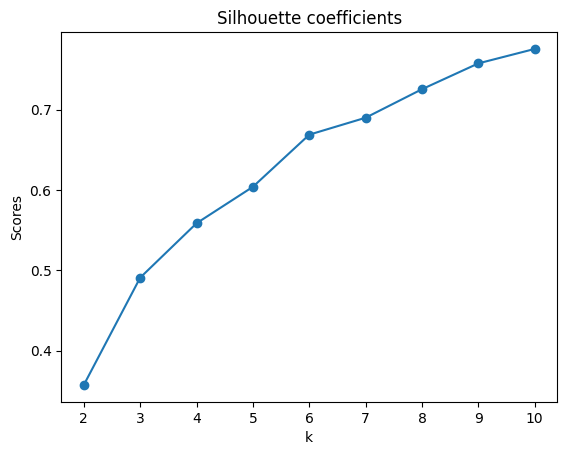

In [417]:
Silhouette_coef(lf_data_scale)

### wcss

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [961.6805767669193, 707.8487401002204, 546.1064547224479, 439.74762173874814, 340.27846923592426, 304.9568668013472, 258.77455090779046, 222.41491022251412, 200.45413504635638]


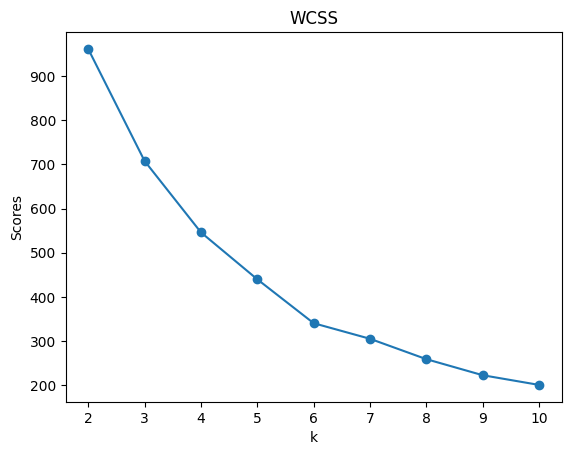

In [418]:
wcss(lf_data_scale)

### kmean

In [419]:
kmeans = KMeans(n_clusters=6, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### pca plot

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Explained variation per principal component: [0.29024999 0.24621482]
Cumulative variance explained by 2 principal components: 53.65%


          sales  category_Coffee  category_Coffee (Bottle)  category_Honey1  \
PC_1  0.001839         0.146394                  0.007310         0.008516   
PC_2  0.002741         0.274222                  0.357942         0.014814   

      category_Juice  category_Salad  category_Salmon Steak  category_Soup  \
PC_1        0.009857        0.164654               0.015219       0.011388   
PC_2        0.044443        0.812734               0.056090       0.052896   

      category_Tea  time_of_day_0_Morning  time_of_day_1_Noon  \
PC_1      0.003592               0.047896            0.671054   
PC_2      0.012327               0.253832            0.245552   

      time_of_day_2_Afternoon  time_of_day_3_Evening   
PC_1                 0.705745                0.013205  
PC_2                 0.035135                0.043414  

*************** Most importan

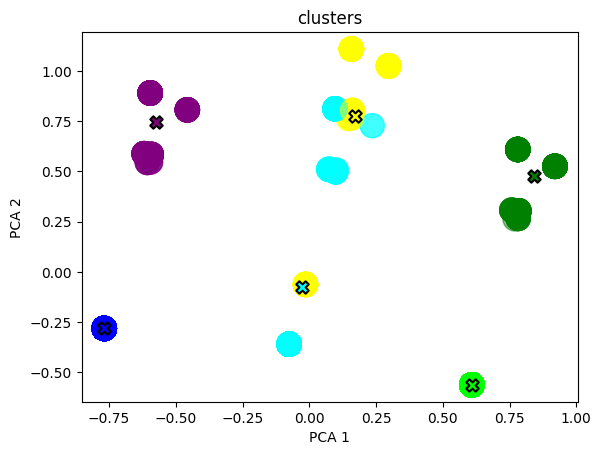

In [420]:
colors = ['purple', 'blue', 'cyan', 'green', 'lime', 'yellow']
pca_plot(lf_data_scale, colors)

In [421]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()
Cluster5 = lf_data_scale[model.labels_ == 4].copy()
Cluster6 = lf_data_scale[model.labels_ == 5].copy()


Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)
Cluster5_inv = scale.inverse_transform(Cluster5)
Cluster6_inv = scale.inverse_transform(Cluster6)


### Cluster 1

In [422]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.0,114.000000,114.000000,114.000000,114.0,114.0,114.0,114.0
mean,172.833909,0.166667,0.421053,0.026316,0.087719,0.0,0.157895,0.105263,0.035088,0.0,0.0,1.0,0.0
std,127.823260,0.374323,0.495908,0.160779,0.284135,0.0,0.366252,0.308247,0.184814,0.0,0.0,0.0,0.0
min,61.452700,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
25%,79.857900,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
50%,104.813500,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
75%,229.573700,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
max,758.694500,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0


In [423]:
print('ลูกค้ากลุ่มตอนบ่าย')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: {}".format(np.array(Cluster1_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: {}".format(np.array(Cluster1_inv['sales']).std()))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: {} คน".format(Cluster1_inv.shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster1_inv.loc[(Cluster1_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนบ่าย
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: 172.8339087719298
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: 127.26139696976894
ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: 114 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee: 19 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Coffee (Bottle): 48 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Honey1: 3 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Juice: 10 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salad: 0 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Salmon Steak: 18 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Soup: 12 คน
ในคลัสเตอร์หนึ่งที่เรามีลูกค้าสั่ง Tea: 4 คน


### Cluster 2

In [424]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,263.000000,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0
mean,161.962260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
std,97.638408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,209.627000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,769.440500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [425]:
print('ลูกค้ากลุ่มตอนบ่าย')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: {}".format(np.array(Cluster2_inv['sales']).std()))
print("ในคลัสเตอร์สองที่เรามีลูกค้า: {} คน".format(Cluster2_inv.shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster2_inv.loc[(Cluster2_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนบ่าย
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: 161.96225969581752
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: 97.45260730940196
ในคลัสเตอร์สองที่เรามีลูกค้า: 263 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Coffee (Bottle): 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Juice: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salad: 263 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Soup: 0 คน
ในคลัสเตอร์สองที่เรามีลูกค้าสั่ง Tea: 0 คน


### Cluster 3

In [426]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,184.000000,184.000000,184.000000,184.0,184.000000,184.000000,184.000000,184.000000,184.0,184.0,184.0,184.0,184.0
mean,208.636746,0.010870,0.135870,0.0,0.048913,0.722826,0.059783,0.021739,0.0,0.0,0.0,0.0,1.0
std,198.428437,0.103972,0.343585,0.0,0.216275,0.448824,0.237731,0.146228,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
25%,104.820175,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
50%,117.291300,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
75%,234.582600,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
max,1530.559500,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0


In [427]:
print('ลูกค้ากลุ่มตอนเย็น')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: {}".format(np.array(Cluster3_inv['sales']).std()))
print("ในคลัสเตอร์สามที่เรามีลูกค้า: {} คน".format(Cluster3_inv.shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster3_inv.loc[(Cluster3_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนเย็น
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: 208.63674619565217
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: 197.88849461550637
ในคลัสเตอร์สามที่เรามีลูกค้า: 184 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee: 2 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Coffee (Bottle): 25 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Juice: 9 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salad: 133 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Salmon Steak: 11 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Soup: 4 คน
ในคลัสเตอร์สามที่เรามีลูกค้าสั่ง Tea: 0 คน


### Cluster 4

In [428]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.0,124.000000,124.000000,124.000000,124.0,124.0,124.0,124.0
mean,167.010089,0.451613,0.250000,0.048387,0.088710,0.0,0.048387,0.104839,0.008065,0.0,1.0,0.0,0.0
std,182.441030,0.499672,0.434769,0.215453,0.285478,0.0,0.215453,0.307588,0.089803,0.0,0.0,0.0,0.0
min,45.744200,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
25%,79.857900,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
50%,96.492000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
75%,192.984000,1.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
max,1162.104800,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0


In [429]:
print('ลูกค้ากลุ่มตอนเที่ยง')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: {}".format(np.array(Cluster4_inv['sales']).std()))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้า: {} คน".format(Cluster4_inv.shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster4_inv.loc[(Cluster4_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนเที่ยง
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: 167.0100887096774
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: 181.70389176923536
ในคลัสเตอร์สี่ที่เรามีลูกค้า: 124 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee: 56 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Coffee (Bottle): 31 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Honey1: 6 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Juice: 11 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salad: 0 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Salmon Steak: 6 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Soup: 13 คน
ในคลัสเตอร์สี่ที่เรามีลูกค้าสั่ง Tea: 1 คน


### Cluster 5

In [430]:
Cluster5_inv = pd.DataFrame(Cluster5_inv,columns=Cluster5.columns)
Cluster5_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,246.000000,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0
mean,159.878537,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
std,112.090730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,104.813500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,171.989350,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,1161.225600,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [431]:
print('ลูกค้ากลุ่มตอนเที่ยง')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่ห้า: {}".format(np.array(Cluster5_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีห้า: {}".format(np.array(Cluster5_inv['sales']).std()))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้า: {} คน".format(Cluster5_inv.shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster5_inv.loc[(Cluster5_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนเที่ยง
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่ห้า: 159.8785365853659
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีห้า: 111.86267085257707
ในคลัสเตอร์ห้าที่เรามีลูกค้า: 246 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Coffee: 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Coffee (Bottle): 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Honey1: 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Juice: 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Salad: 246 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Soup: 0 คน
ในคลัสเตอร์ห้าที่เรามีลูกค้าสั่ง Tea: 0 คน


### Cluster 6

In [432]:
Cluster6_inv = pd.DataFrame(Cluster6_inv,columns=Cluster6.columns)
Cluster6_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.0,105.000000,105.000000,105.0,105.0,105.0,105.0
mean,141.021149,0.390476,0.285714,0.019048,0.009524,0.228571,0.0,0.047619,0.019048,1.0,0.0,0.0,0.0
std,99.066166,0.490197,0.453921,0.137348,0.097590,0.421927,0.0,0.213980,0.137348,0.0,0.0,0.0,0.0
min,59.067500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0
25%,79.857900,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0
50%,96.500900,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0
75%,159.715800,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0
max,618.037300,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0,0.0,0.0,0.0


In [433]:
print('ลูกค้ากลุ่มตอนเช้า')
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หก: {}".format(np.array(Cluster6_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหก: {}".format(np.array(Cluster6_inv['sales']).std()))
print("ในคลัสเตอร์หกที่เรามีลูกค้า: {} คน".format(Cluster6_inv.shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Coffee: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Coffee'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Coffee (Bottle): {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Honey1: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Honey1'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Juice: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Juice'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Salad: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Salad'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Salmon Steak: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Soup: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Soup'] == 1.0)].shape[0]))
print("ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Tea: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Tea'] == 1.0)].shape[0]))

ลูกค้ากลุ่มตอนเช้า
ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หก: 141.02114857142857
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหก: 98.5932939031136
ในคลัสเตอร์หกที่เรามีลูกค้า: 105 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Coffee: 41 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Coffee (Bottle): 30 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Honey1: 2 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Juice: 1 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Salad: 24 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Salmon Steak: 0 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Soup: 5 คน
ในคลัสเตอร์หกที่เรามีลูกค้าสั่ง Tea: 2 คน


### Experiment 2 Summary

kmean clustering ทำการแบ่งกลุ่มของข้อมูลจากประเภทของเมนูออกเป็น 6 กลุ่มหลักๆ ได้แก่ กลุ่มลูกค้าตอนเช้า กลุ่มลูกค้าตอนเที่ยงที่ทานสลัด กลุ่มลูกค้าตอนเที่ยงที่ไม่ทานสลัด กลุ่มลูกค้าตอนบ่ายที่ทานสลัด กลุ่มลูกค้าตอนบ่ายที่ไม่ทานสลัด และกลุ่มลูกค้าตอนเย็น

โดยกลุ่มลูกค้าตอนเช้านั้น เป็นกลุ่มที่มีสัดส่วนการซื้อกาแฟเทียบกับอาหารอื่นๆมากที่สุด

กลุ่มลูกค้าตอนเที่ยงที่ทานสลัด มีมากกว่ากลุ่มที่ไม่ทาน แต่ว่ากลุ่มที่ไม่ทานสลัดมียอดบิลเฉลี่ยมากกว่า

กลุ่มลูกค้าตอนบ่ายที่ทานสลัด เป็นกลุ่มที่มีลูกค้ามากที่สุด แต่ว่ากลุ่มที่ไม่ทานสลัดมียอดบิลเฉลี่ยมากกว่า

กลุ่มลูกค้าตอนเย็น เป็นกลุ่มที่มียอดบิลเฉลี่ยสูงที่สุด ที่ประมาณ 208 บาท

## Experiment 3

customer characteristics clustering

In [434]:
lf_data = lf_data_ori[['member_id', 'sales', 'sex','age','location']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1603 non-null   object 
 1   sales      2800 non-null   float64
 2   sex        1385 non-null   object 
 3   age        1601 non-null   float64
 4   location   1601 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.5+ KB


,member_id,sales,sex,age,location
0,None,79.8579,None,NaN,None
1,14bc04ee,79.8579,F,59.0,North
2,None,79.8579,None,NaN,None
3,8e60e131,79.8579,M,57.0,North
4,2c156018,79.8579,M,41.0,North


In [435]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1385 entries, 1 to 2797
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1385 non-null   object 
 1   sales      1385 non-null   float64
 2   sex        1385 non-null   object 
 3   age        1385 non-null   float64
 4   location   1385 non-null   object 
dtypes: float64(2), object(3)
memory usage: 64.9+ KB


In [436]:
aggregations = {
    'sales': 'sum',
    'sex': 'max', 
    'age': 'max',  
    'location': 'max',
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  910 non-null    object 
 1   sales      910 non-null    float64
 2   sex        910 non-null    object 
 3   age        910 non-null    float64
 4   location   910 non-null    object 
dtypes: float64(2), object(3)
memory usage: 35.7+ KB


,member_id,sales,sex,age,location
0,004a4488,234.5826,F,54.0,South
1,009e11b6,71.5453,F,26.0,East
2,00f07ddd,209.6270,M,42.0,North
3,00f0e4d4,117.2913,F,23.0,South
4,012a8260,117.2913,F,30.0,West


In [437]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     910 non-null    float64
 1   sex       910 non-null    object 
 2   age       910 non-null    float64
 3   location  910 non-null    object 
dtypes: float64(2), object(2)
memory usage: 28.6+ KB


,sales,sex,age,location
0,234.5826,F,54.0,South
1,71.5453,F,26.0,East
2,209.6270,M,42.0,North
3,117.2913,F,23.0,South
4,117.2913,F,30.0,West


In [438]:
encode = LabelEncoder()
lf_data['sex'] = encode.fit_transform(lf_data['sex'])
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     910 non-null    float64
 1   sex       910 non-null    int64  
 2   age       910 non-null    float64
 3   location  910 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 28.6+ KB


,sales,sex,age,location
0,234.5826,0,54.0,South
1,71.5453,0,26.0,East
2,209.6270,1,42.0,North
3,117.2913,0,23.0,South
4,117.2913,0,30.0,West


In [439]:
lf_data = pd.get_dummies(lf_data, columns=['location'], prefix=['location'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           910 non-null    float64
 1   sex             910 non-null    int64  
 2   age             910 non-null    float64
 3   location_East   910 non-null    int64  
 4   location_North  910 non-null    int64  
 5   location_South  910 non-null    int64  
 6   location_West   910 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 49.9 KB


,sales,sex,age,location_East,location_North,location_South,location_West
0,234.5826,0,54.0,0,0,1,0
1,71.5453,0,26.0,1,0,0,0
2,209.6270,1,42.0,0,1,0,0
3,117.2913,0,23.0,0,0,1,0
4,117.2913,0,30.0,0,0,0,1


In [440]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,sex,age,location_East,location_North,location_South,location_West
0,0.193668,0.0,0.642857,0.0,0.0,1.0,0.0
1,0.052558,0.0,0.142857,1.0,0.0,0.0,0.0
2,0.172069,1.0,0.428571,0.0,1.0,0.0,0.0
3,0.092152,0.0,0.089286,0.0,0.0,1.0,0.0
4,0.092152,0.0,0.214286,0.0,0.0,0.0,1.0


### Silhouette_coef

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.3443800267310946, 0.511130642366167, 0.5892426023151661, 0.6164281677742628, 0.6709843923702822, 0.7168617748493408, 0.7340683403358456, 0.6674832169284702, 0.6260381591393258]


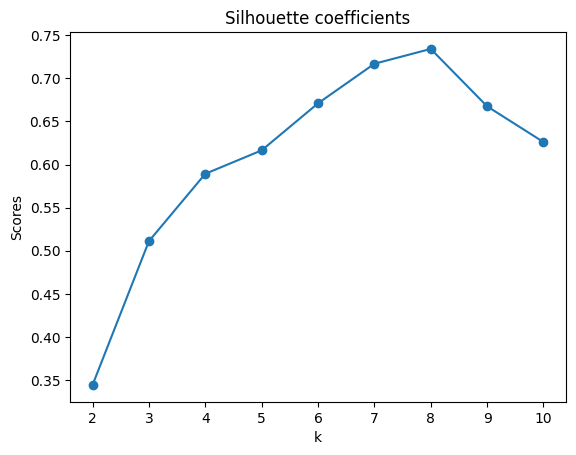

In [441]:
Silhouette_coef(lf_data_scale)

### wcss

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

[2, 3, 4, 5, 6, 7, 8, 9, 10] [652.3371580968007, 395.5074506413759, 271.14980228378465, 192.51306747061318, 127.67268524652303, 72.37266139396174, 51.10876229158799, 46.12711588300089, 41.01025288519802]


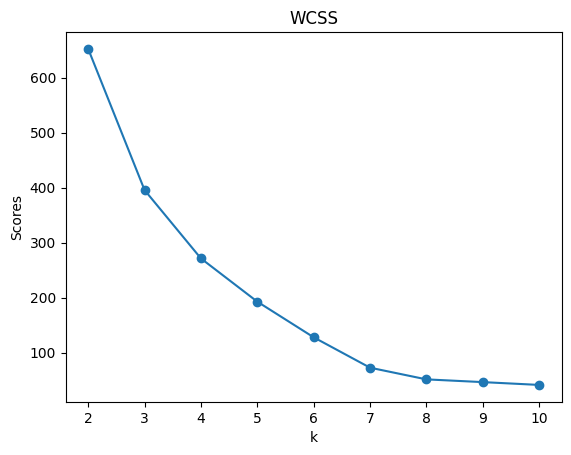

In [442]:
wcss(lf_data_scale)

### kmean

In [443]:
kmeans = KMeans(n_clusters=8, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### pca plot

/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Explained variation per principal component: [0.32647843 0.26667396]
Cumulative variance explained by 2 principal components: 59.32%


          sales       sex       age  location_East  location_North  \
PC_1  0.002693  0.002001  0.006068       0.024916        0.796894   
PC_2  0.011031  0.060354  0.004558       0.031467        0.219577   

      location_South  location_West  
PC_1        0.568081       0.203897  
PC_2        0.587604       0.775714  

*************** Most important features *************************
As per PC 1:
 location_North    0.796894
location_South    0.568081
Name: PC_1, dtype: float64


As per PC 2:
 location_South    0.587604
location_West     0.775714
Name: PC_2, dtype: float64

******************************************************************


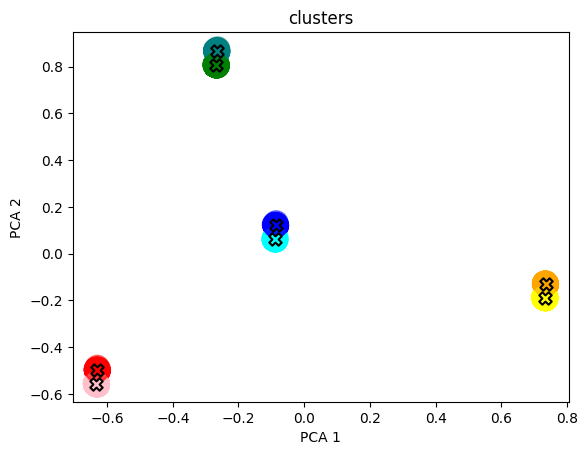

In [444]:
colors = ['orange', 'pink', 'green', 'yellow', 'blue', 'teal', 'red', 'cyan']
pca_plot(lf_data_scale, colors)

In [445]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()
Cluster5 = lf_data_scale[model.labels_ == 4].copy()
Cluster6 = lf_data_scale[model.labels_ == 5].copy()
Cluster7 = lf_data_scale[model.labels_ == 6].copy()
Cluster8 = lf_data_scale[model.labels_ == 7].copy()


Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)
Cluster5_inv = scale.inverse_transform(Cluster5)
Cluster6_inv = scale.inverse_transform(Cluster6)
Cluster7_inv = scale.inverse_transform(Cluster7)
Cluster8_inv = scale.inverse_transform(Cluster8)


### Cluster 1

In [446]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,132.000000,132.0,132.000000,132.0,132.0,132.0,132.0
mean,149.070942,1.0,42.484848,0.0,1.0,0.0,0.0
std,90.635782,0.0,11.303911,0.0,0.0,0.0,0.0
min,67.380100,1.0,18.000000,0.0,1.0,0.0,0.0
25%,96.492000,1.0,36.000000,0.0,1.0,0.0,0.0
50%,117.291300,1.0,41.000000,0.0,1.0,0.0,0.0
75%,210.877000,1.0,50.000000,0.0,1.0,0.0,0.0
max,561.500900,1.0,70.000000,0.0,1.0,0.0,0.0


In [447]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: {}".format(np.array(Cluster1_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: {}".format(np.array(Cluster1_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์หนึ่ง: {}".format(np.array(Cluster1_inv['age']).mean()))
print("ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: {} คน".format(Cluster1_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster1_inv.loc[(Cluster1_inv['sex'] == 1.0)].shape[0], Cluster1_inv.loc[(Cluster1_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster1_inv['location_North']).sum(), np.array(Cluster1_inv['location_South']).sum(), np.array(Cluster1_inv['location_East']).sum(), np.array(Cluster1_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หนึ่ง: 149.07094166666667
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหนึ่ง: 90.29181181918054
อายุเฉลี่ยของลูกค้าในคลัสเตอร์หนึ่ง: 42.484848484848484
ในคลัสเตอร์หนึ่งที่เรามีลูกค้า: 132 คน
มีผู้ชาย 132 คน และ ผู้หญิง 0 คน
มีภาคเหนือ 132.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 0.0 คน


### Cluster 2

In [448]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,162.000000,162.0,162.000000,162.0,162.0,162.0,162.0
mean,153.877531,0.0,42.629630,0.0,0.0,1.0,0.0
std,103.639521,0.0,12.161383,0.0,0.0,0.0,0.0
min,10.820600,0.0,18.000000,0.0,0.0,1.0,0.0
25%,96.494225,0.0,34.250000,0.0,0.0,1.0,0.0
50%,117.291300,0.0,42.000000,0.0,0.0,1.0,0.0
75%,196.110125,0.0,52.000000,0.0,0.0,1.0,0.0
max,758.694500,0.0,71.000000,0.0,0.0,1.0,0.0


In [449]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: {}".format(np.array(Cluster2_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์สอง: {}".format(np.array(Cluster2_inv['age']).mean()))
print("ในคลัสเตอร์สองที่เรามีลูกค้า: {} คน".format(Cluster2_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster2_inv.loc[(Cluster2_inv['sex'] == 1.0)].shape[0], Cluster2_inv.loc[(Cluster2_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster2_inv['location_North']).sum(), np.array(Cluster2_inv['location_South']).sum(), np.array(Cluster2_inv['location_East']).sum(), np.array(Cluster2_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สอง: 153.8775314814815
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสอง: 103.31915028367827
อายุเฉลี่ยของลูกค้าในคลัสเตอร์สอง: 42.629629629629626
ในคลัสเตอร์สองที่เรามีลูกค้า: 162 คน
มีผู้ชาย 0 คน และ ผู้หญิง 162 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 162.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 0.0 คน


### Cluster 3

In [450]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()


,sales,sex,age,location_East,location_North,location_South,location_West
count,136.000000,136.0,136.000000,136.0,136.0,136.0,136.0
mean,174.698919,0.0,41.426471,0.0,0.0,0.0,1.0
std,106.251835,0.0,12.106706,0.0,0.0,0.0,0.0
min,71.545300,0.0,18.000000,0.0,0.0,0.0,1.0
25%,104.813500,0.0,34.000000,0.0,0.0,0.0,1.0
50%,126.479550,0.0,42.000000,0.0,0.0,0.0,1.0
75%,214.872650,0.0,51.000000,0.0,0.0,0.0,1.0
max,619.724700,0.0,72.000000,0.0,0.0,0.0,1.0


In [451]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: {}".format(np.array(Cluster3_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์สาม: {}".format(np.array(Cluster3_inv['age']).mean()))
print("ในคลัสเตอร์สามที่เรามีลูกค้า: {} คน".format(Cluster3_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster3_inv.loc[(Cluster3_inv['sex'] == 1.0)].shape[0], Cluster3_inv.loc[(Cluster3_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster3_inv['location_North']).sum(), np.array(Cluster3_inv['location_South']).sum(), np.array(Cluster3_inv['location_East']).sum(), np.array(Cluster3_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สาม: 174.69891911764705
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสาม: 105.86048290245566
อายุเฉลี่ยของลูกค้าในคลัสเตอร์สาม: 41.4264705882353
ในคลัสเตอร์สามที่เรามีลูกค้า: 136 คน
มีผู้ชาย 0 คน และ ผู้หญิง 136 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 136.0 คน


### Cluster 4

In [452]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()


,sales,sex,age,location_East,location_North,location_South,location_West
count,194.000000,194.0,194.000000,194.0,194.0,194.0,194.0
mean,176.404344,0.0,41.211340,0.0,1.0,0.0,0.0
std,136.422369,0.0,11.187598,0.0,0.0,0.0,0.0
min,16.641200,0.0,18.000000,0.0,1.0,0.0,0.0
25%,104.813500,0.0,34.000000,0.0,1.0,0.0,0.0
50%,117.291300,0.0,41.000000,0.0,1.0,0.0,0.0
75%,209.627000,0.0,49.750000,0.0,1.0,0.0,0.0
max,1166.207800,0.0,73.000000,0.0,1.0,0.0,0.0


In [453]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: {}".format(np.array(Cluster4_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์สี่: {}".format(np.array(Cluster4_inv['age']).mean()))
print("ในคลัสเตอร์สี่ที่เรามีลูกค้า: {} คน".format(Cluster4_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster4_inv.loc[(Cluster4_inv['sex'] == 1.0)].shape[0], Cluster4_inv.loc[(Cluster4_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster4_inv['location_North']).sum(), np.array(Cluster4_inv['location_South']).sum(), np.array(Cluster4_inv['location_East']).sum(), np.array(Cluster4_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่สี่: 176.40434381443302
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีสี่: 136.07031066850436
อายุเฉลี่ยของลูกค้าในคลัสเตอร์สี่: 41.21134020618557
ในคลัสเตอร์สี่ที่เรามีลูกค้า: 194 คน
มีผู้ชาย 0 คน และ ผู้หญิง 194 คน
มีภาคเหนือ 194.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 0.0 คน


### Cluster 5

In [454]:
Cluster5_inv = pd.DataFrame(Cluster5_inv,columns=Cluster5.columns)
Cluster5_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,41.000000,41.0,41.000000,41.0,41.0,41.0,41.0
mean,180.571417,1.0,42.682927,1.0,0.0,0.0,0.0
std,173.719774,0.0,13.069887,0.0,0.0,0.0,0.0
min,71.545300,1.0,18.000000,1.0,0.0,0.0,0.0
25%,104.813500,1.0,37.000000,1.0,0.0,0.0,0.0
50%,117.291300,1.0,43.000000,1.0,0.0,0.0,0.0
75%,209.627000,1.0,52.000000,1.0,0.0,0.0,0.0
max,1133.774400,1.0,74.000000,1.0,0.0,0.0,0.0


In [455]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่ห้า: {}".format(np.array(Cluster5_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีห้า: {}".format(np.array(Cluster5_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์ห้า: {}".format(np.array(Cluster5_inv['age']).mean()))
print("ในคลัสเตอร์ห้าที่เรามีลูกค้า: {} คน".format(Cluster5_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster5_inv.loc[(Cluster5_inv['sex'] == 1.0)].shape[0], Cluster5_inv.loc[(Cluster5_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster5_inv['location_North']).sum(), np.array(Cluster5_inv['location_South']).sum(), np.array(Cluster5_inv['location_East']).sum(), np.array(Cluster5_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่ห้า: 180.57141707317072
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีห้า: 171.58816278322033
อายุเฉลี่ยของลูกค้าในคลัสเตอร์ห้า: 42.68292682926829
ในคลัสเตอร์ห้าที่เรามีลูกค้า: 41 คน
มีผู้ชาย 41 คน และ ผู้หญิง 0 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 41.0 คน และ ตะวันตก 0.0 คน


### Cluster 6

In [456]:
Cluster6_inv = pd.DataFrame(Cluster6_inv,columns=Cluster6.columns)
Cluster6_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,93.000000,93.0,93.000000,93.0,93.0,93.0,93.0
mean,172.883101,1.0,43.397849,0.0,0.0,0.0,1.0
std,168.029576,0.0,11.823098,0.0,0.0,0.0,0.0
min,45.744200,1.0,18.000000,0.0,0.0,0.0,1.0
25%,96.492000,1.0,36.000000,0.0,0.0,0.0,1.0
50%,117.291300,1.0,44.000000,0.0,0.0,0.0,1.0
75%,176.358800,1.0,51.000000,0.0,0.0,0.0,1.0
max,1117.992900,1.0,72.000000,0.0,0.0,0.0,1.0


In [457]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หก: {}".format(np.array(Cluster6_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหก: {}".format(np.array(Cluster6_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์หก: {}".format(np.array(Cluster6_inv['age']).mean()))
print("ในคลัสเตอร์หกที่เรามีลูกค้า: {} คน".format(Cluster6_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster6_inv.loc[(Cluster6_inv['sex'] == 1.0)].shape[0], Cluster6_inv.loc[(Cluster6_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster6_inv['location_North']).sum(), np.array(Cluster6_inv['location_South']).sum(), np.array(Cluster6_inv['location_East']).sum(), np.array(Cluster6_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่หก: 172.88310107526883
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีหก: 167.12374961031188
อายุเฉลี่ยของลูกค้าในคลัสเตอร์หก: 43.39784946236559
ในคลัสเตอร์หกที่เรามีลูกค้า: 93 คน
มีผู้ชาย 93 คน และ ผู้หญิง 0 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 93.0 คน


### Cluster 7

In [458]:
Cluster7_inv = pd.DataFrame(Cluster7_inv,columns=Cluster7.columns)
Cluster7_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,108.000000,108.0,108.000000,108.0,108.0,108.0,108.0
mean,159.579756,1.0,41.259259,0.0,0.0,1.0,0.0
std,138.011555,0.0,11.897829,0.0,0.0,0.0,0.0
min,10.820600,1.0,18.000000,0.0,0.0,1.0,0.0
25%,96.492000,1.0,34.500000,0.0,0.0,1.0,0.0
50%,117.291300,1.0,42.000000,0.0,0.0,1.0,0.0
75%,188.838825,1.0,50.250000,0.0,0.0,1.0,0.0
max,1161.225600,1.0,66.000000,0.0,0.0,1.0,0.0


In [459]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่เจ็ด: {}".format(np.array(Cluster7_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีเจ็ด: {}".format(np.array(Cluster7_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์เจ็ด: {}".format(np.array(Cluster7_inv['age']).mean()))
print("ในคลัสเตอร์เจ็ดที่เรามีลูกค้า: {} คน".format(Cluster7_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster7_inv.loc[(Cluster7_inv['sex'] == 1.0)].shape[0], Cluster7_inv.loc[(Cluster7_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster7_inv['location_North']).sum(), np.array(Cluster7_inv['location_South']).sum(), np.array(Cluster7_inv['location_East']).sum(), np.array(Cluster7_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่เจ็ด: 159.5797564814815
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีเจ็ด: 137.37112706969265
อายุเฉลี่ยของลูกค้าในคลัสเตอร์เจ็ด: 41.25925925925926
ในคลัสเตอร์เจ็ดที่เรามีลูกค้า: 108 คน
มีผู้ชาย 108 คน และ ผู้หญิง 0 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 108.0 คน ภาคตะวันออก 0.0 คน และ ตะวันตก 0.0 คน


### Cluster 8

In [460]:
Cluster8_inv = pd.DataFrame(Cluster8_inv,columns=Cluster8.columns)
Cluster8_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,44.000000,44.0,44.000000,44.0,44.0,44.0,44.0
mean,184.992332,0.0,40.250000,1.0,0.0,0.0,0.0
std,167.663611,0.0,11.582113,0.0,0.0,0.0,0.0
min,71.545300,0.0,18.000000,1.0,0.0,0.0,0.0
25%,93.374775,0.0,33.750000,1.0,0.0,0.0,0.0
50%,117.291300,0.0,39.500000,1.0,0.0,0.0,0.0
75%,223.354800,0.0,47.250000,1.0,0.0,0.0,0.0
max,928.321500,0.0,64.000000,1.0,0.0,0.0,0.0


In [461]:
print("ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่แปด: {}".format(np.array(Cluster8_inv['sales']).mean()))
print("ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีแปด: {}".format(np.array(Cluster8_inv['sales']).std()))
print("อายุเฉลี่ยของลูกค้าในคลัสเตอร์แปด: {}".format(np.array(Cluster8_inv['age']).mean()))
print("ในคลัสเตอร์แปดที่เรามีลูกค้า: {} คน".format(Cluster8_inv.shape[0]))
print("มีผู้ชาย {} คน และ ผู้หญิง {} คน".format(Cluster8_inv.loc[(Cluster8_inv['sex'] == 1.0)].shape[0], Cluster8_inv.loc[(Cluster8_inv['sex'] == 0.0)].shape[0]))
print("มีภาคเหนือ {} คน ภาคใต้ {} คน ภาคตะวันออก {} คน และ ตะวันตก {} คน".format(np.array(Cluster8_inv['location_North']).sum(), np.array(Cluster8_inv['location_South']).sum(), np.array(Cluster8_inv['location_East']).sum(), np.array(Cluster8_inv['location_West']).sum()))

ยอดบิลเฉลี่ยสำหรับลูกค้าในคลัสเตอร์ที่แปด: 184.99233181818184
ค่าเบี่ยงเบนค่าเฉลี่ยยอดบิล สำหรับลูกค้าในกลุ่มทีแปด: 165.74739284378964
อายุเฉลี่ยของลูกค้าในคลัสเตอร์แปด: 40.25
ในคลัสเตอร์แปดที่เรามีลูกค้า: 44 คน
มีผู้ชาย 0 คน และ ผู้หญิง 44 คน
มีภาคเหนือ 0.0 คน ภาคใต้ 0.0 คน ภาคตะวันออก 44.0 คน และ ตะวันตก 0.0 คน


### Experiment 3 Summary

kmean clustering ทำการแบ่งกลุ่มของข้อมูลจากประเภทของเมนูออกเป็น 8 โดยแบ่งตามภูมิภาค และเพศของลูกค้าเป็นหลัก ซึ่งทั้ง 8 cluster นั้น มีอายุเฉลี่ยในกลุ่มที่ใกล้เคียงกัน โดยภูมิภาคที่มียอดบิลเฉลี่ยเรียงจากมากไปน้อยเป็นดังนี้ [ภาคตะวันออก ภาคตะวันตก ภาคเหนือ และภาคใต้] 

ในทุกภูมิภาคมีจำนวนลูกค้าผู้หญิงมากกว่าลูกค้าผู้ชาย

ภูมิภาคตะวันออกมีลูกค้าน้อยที่สุด แต่มียอดบิลเฉลี่ยสูงที่สุด (ควรมีการออกแคมเปน เพื่อเพิ่มยอดลูกค้าในกลุ่มนี้)

ภูมิภาคเหนือ มีจำนวนลูกค้ามากที่สุด

ผู้ชายภาคเหนือ มียอดบิลเฉลี่ยต่ำที่สุด (ควรมีการกระตุ้นยอดขายของคนในกลุ่มนี้ให้มากขึ้น)

